# Part 3: Training and deploying an Amazon Fraud Detector model

<div class="alert alert-warning"> <h4><strong>💡 NOTE</strong></h4>
In order to execute this notebook, you must first execute the previous notebook <a href="./2-afd-model-setup.ipynb">2-afd-model-setup.ipynb</a>.

</div>

## Overview <a id='overview'></a>

* [Notebook 1: Data Preparation, Process, and Store Features](./1-data-analysis-prep.ipynb)
* [Notebook 2: Amazon Fraud Detector Model Setup](./2-afd-model-setup.ipynb)
* **[Notebook 3: Model training, deployment, real-time and batch inference](./3-afd-model-train-deploy.ipynb)**
    * **[Introduction](#intro)**
    * **[Notebook Setup](#setup)**
    * **[Set region, boto3 and SageMaker SDK variables](#setup2)**
    * **[Create & Train your Model](#train)**
    * **[Check model performance and activate](#activate)**
    * **[Create rules and detector](#detector)**
    * **[Make Predictions](#predictions)**
    * **[Conclusion](#conclusion)**
* [Notebook 4: Create an end-to-end pipeline](./4-afd-pipeline.ipynb)

### 1. Introduction <a id="intro"></a>
___
<a href="#overview">overview</a>

Amazon Fraud Detector Online Fraud Insights is a supervised machine learning model designed to detect a variety of online fraud and risks. Because the model is supervised, it requires historical examples of fraudulent and legitimate events to train the model.

The Online Fraud Insights model uses an ensemble of machine-learning algorithms for data enrichment, transformation, and fraud classification. As part of the model training process, Online Fraud Insights enriches raw data elements like IP address and BIN number with 3rd party data such as the geo-location of the IP address or the issuing bank for a credit card. In addition to 3rd party data, Online Fraud Insights uses deep learning algorithms leveraging fraud patterns seen at Amazon and AWS. These fraud patterns become input features to your model using a gradient tree boosting algorithm. 

As part of this notebook, we will create and train an Amazon Fraud Detector [Online Fraud Insights](https://docs.aws.amazon.com/frauddetector/latest/ug/online-fraud-insights.html) model. Once a model is created and trained, we can create a detector which can be used to perform inferences.

A detector is a rules-based categorization engine that predicts predefined outcomes based on user configuration. For this tutorial, you define the model score thresholds as rules for the detector.

Models can either be trained within Amazon Fraud Detector using custom user data or they can be accessed from precreated Amazon Sagemaker endpoints.

The high-level configuration flow is depicted in the following diagram.

<img src="images/nb3.png" width="600" height="800"/>

### 2. Setup <a id="setup"></a>
----
<a href="#overview">overview</a>

As part of setup, we will retrieve those variables in order to use them here. We will also import some required libraries in this section.

In [22]:
from IPython.core.display import display, HTML
from IPython.display import clear_output, JSON

display(HTML("<style>.container { width:90% }</style>"))
# ------------------------------------------------------------------

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os
import sys
import time
import json
import uuid 
from datetime import datetime
import boto3
import sagemaker

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

# -- sklearn --
from sklearn.metrics import roc_curve, roc_auc_score, auc, roc_auc_score
%matplotlib inline

The previous notebook [2-afd-model-setup.ipynb](./2-afd-model-setup.ipynb) defines and saves a few variables into the Jupyter cache using `%store` magic command. We will retrieve those variables to be used in this notebook. 

In [43]:
# Retrieve cached variables

%store -r ENTITY_TYPE
%store -r ENTITY_DESC
%store -r EVENT_TYPE
%store -r EVENT_DESC
%store -r MODEL_NAME
%store -r MODEL_DESC
%store -r DETECTOR_NAME
%store -r DETECTOR_DESC
%store -r S3_FILE_LOC
%store -r trainingDataSchema
%store -r eventVariables

display(HTML(f"<p>Retrieved values: <ul><li>{ENTITY_TYPE}</li><li>{ENTITY_DESC}</li><li>{EVENT_TYPE}</li><li>{EVENT_DESC}</li><li>{MODEL_NAME}</li><li>{MODEL_DESC}</li><li>{DETECTOR_NAME}</li><li>{DETECTOR_DESC}</li><li>{S3_FILE_LOC}</li></ul></p>"))
display(JSON(trainingDataSchema))

<IPython.core.display.JSON object>

### 3. Set region, boto3 and SageMaker SDK variables <a id="setup2"></a>
---
<a href="#overview">overview</a>

We will initialize a Fraud Detector, S3 and Sagemaker Boto3 client objects.

In [24]:
#You can change this to a region of your choice
region = sagemaker.Session().boto_region_name
print("Using AWS Region: {}".format(region))

Using AWS Region: us-east-2


In [25]:
boto3.setup_default_session(region_name=region)

boto_session = boto3.Session(region_name=region)

# -- initialize S3 Client
s3_client = boto3.client('s3', region_name=region)

# -- initialize the AFD client 
client = boto3.client('frauddetector')

sagemaker_boto_client = boto_session.client('sagemaker')

sagemaker_session = sagemaker.session.Session(
    boto_session=boto_session,
    sagemaker_client=sagemaker_boto_client)

# -- suffix is appended to detector and model name for uniqueness  
sufx   = datetime.now().strftime("%Y%m%d")

We will get the SageMaker Execution Role 

In [26]:
print('SageMaker Role:', sagemaker.get_execution_role().split('/')[-1])

ARN_ROLE = sagemaker.get_execution_role()

SageMaker Role: AmazonSageMaker-ExecutionRole-20201030T135016


### 4. Create & Train your Model <a id="train"></a>
-----
<a href="#overview">overview</a>

An Amazon Fraud Detector model version is created by calling the [CreateModel](https://docs.aws.amazon.com/frauddetector/latest/api/API_CreateModel.html) and [CreateModelVersion](https://docs.aws.amazon.com/frauddetector/latest/api/API_CreateModelVersion.html) operations. 

* CreateModel initiates the model, which acts as a container for your model versions. 
* CreateModelVersion starts the training process, which results in a specific version of the model. A new version of the solution is created each time you call CreateModelVersion.

As stated earlier, we will initialize a model of `modelType = ONLINE_FRAUD_INSIGHTS`.


In [27]:
# -- create AFD model --
response = client.create_model(
   description   =  MODEL_DESC,
   eventTypeName = EVENT_TYPE,
   modelId       = MODEL_NAME,
   modelType   = 'ONLINE_FRAUD_INSIGHTS')

# Display output
display(HTML("<h4>Initialize Model</h4>"))
display(JSON(response))

<IPython.core.display.JSON object>

Now we will train our first version using the `CreateModelVersion` API. `TrainingDataSource` and `ExternalEventsDetail` specify the source and Amazon S3 location of the training data set. `TrainingDataSchema` specifies how Amazon Fraud Detector should interpret the training data, specifically which event variables to include and how to classify the event labels.

<div class="alert alert-info"> <h4><strong>💡 NOTE</strong></h4>
Running the code cell below will kick-off the training process asynchronously. Training can take somewhere from 30 mins to 60 mins. At anypoint during the training, you can cancel the training by calling <a href="https://docs.aws.amazon.com/frauddetector/latest/api/API_UpdateModelVersionStatus.html">UpdateModelVersionStatus</a> and updating the status to <strong>TRAINING_CANCELLED</strong>.
</div>

We will also need to provide an IAM Role ARN to the create_model_version call. This is different than the IAM Role that we have been using so far. The `dataAccessRoleArn` is an IAM role that should be assumable by Amazon Fraud Detector, so you will need to create a "New" IAM Role and assign it S3 read/write policy with a trust relationship with Amazon Fraud Detector. Here's what the IAM Policy looks like [**Note**: replace the bucket name appropriately]

```json
{
    "Version": "2012-10-17",
    "Statement": [
        {
            "Action": [
                "s3:ListBucket",
                "s3:GetBucketLocation"
            ],
            "Effect": "Allow",
            "Resource": [
                "arn:aws:s3:::YOUR_BUCKET_NAME"
            ]
        },
        {
            "Action": [
                "s3:GetObject"
            ],
            "Effect": "Allow",
            "Resource": [
                "arn:aws:s3:::YOUR_BUCKET_NAME/*"
            ]
        }
    ]
}
```

In [63]:
# Replace with the Role ARN

DATA_ACCESS_ROLE_ARN="arn:aws:iam::965425568475:role/service-role/AmazonFraudDetector-DataAccessRole-1620923454652"
%store DATA_ACCESS_ROLE_ARN


Stored 'DATA_ACCESS_ROLE_ARN' (str)


In [44]:

response = client.create_model_version(
    modelId     = MODEL_NAME,
    modelType   = 'ONLINE_FRAUD_INSIGHTS',
    trainingDataSource = 'EXTERNAL_EVENTS',
    trainingDataSchema = trainingDataSchema,
    externalEventsDetail = {
        'dataLocation'     : S3_FILE_LOC,
        'dataAccessRoleArn': DATA_ACCESS_ROLE_ARN
    }
)

# Display output
display(HTML("<h4>Model training</h4>"))
display(JSON(response))

<IPython.core.display.JSON object>

You can check the progress of your model training by running the code cell below. Alternatively, you may also check the status of the training process via the Amazon Fraud Detector Console.

In [47]:
# Optional code cell
from datetime import datetime

print("Wait for model training to complete...")
stime = time.time()
while True:
    current_time = datetime.now()
    clear_output(wait=True)
    response = client.get_model_version(modelId=MODEL_NAME, modelType = "ONLINE_FRAUD_INSIGHTS", modelVersionNumber = '1.0')
    if response['status'] == 'TRAINING_IN_PROGRESS':
        print(f"{current_time}: current progress: {(time.time() - stime)/60:{3}.{3}} minutes")
        time.sleep(60)  # -- sleep for 60 seconds 
    if response['status'] != 'TRAINING_IN_PROGRESS':
        print(f"{current_time}: Model status : {response['status']}")
        break
        
etime = time.time()

# -- summarize -- 
print("\nModel training complete")
print("\nElapsed time : %s" % (etime - stime) + " seconds \n"  )
display(JSON(response))

2021-05-13 22:21:04.317898: Model status : TRAINING_COMPLETE

Model training complete

Elapsed time : 0.24937129020690918 seconds 



<IPython.core.display.JSON object>

### 5. Check model performance and activate <a id="activate"></a>
---

Once training is complete, the model version status willupdate to `TRAINING_COMPLETE`. You can review model performance using the Amazon Fraud Detector console or by calling [DescribeModelVersions](https://docs.aws.amazon.com/frauddetector/latest/api/API_DescribeModelVersions.html) API.

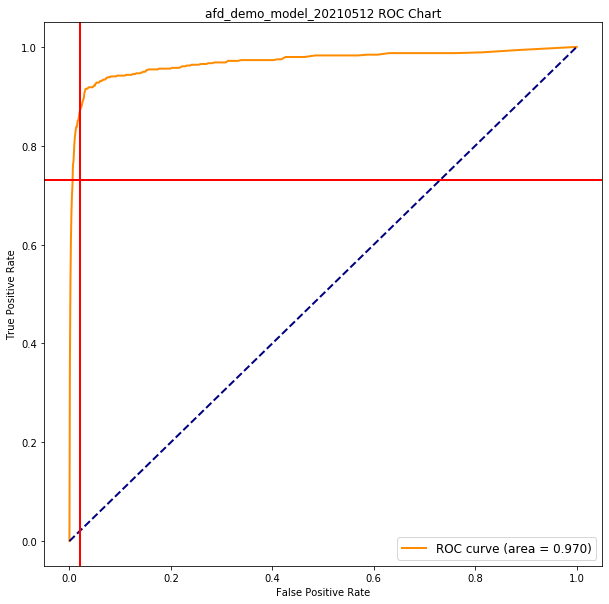

In [48]:

auc = client.describe_model_versions(
    modelId= MODEL_NAME,
    modelVersionNumber='1.0',
    modelType='ONLINE_FRAUD_INSIGHTS',
    maxResults=10
)['modelVersionDetails'][0]['trainingResult']['trainingMetrics']['auc']


df_model = pd.DataFrame(client.describe_model_versions(
    modelId= MODEL_NAME,
    modelVersionNumber='1.0',
    modelType='ONLINE_FRAUD_INSIGHTS',
    maxResults=10
)['modelVersionDetails'][0]['trainingResult']['trainingMetrics']['metricDataPoints'])


plt.figure(figsize=(10,10))
plt.plot(df_model["fpr"], df_model["tpr"], color='darkorange',
         lw=2, label='ROC curve (area = %0.3f)' % auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title( MODEL_NAME + ' ROC Chart')
plt.legend(loc="lower right",fontsize=12)
plt.axvline(x = 0.02 ,linewidth=2, color='r')
plt.axhline(y = 0.73 ,linewidth=2, color='r')
plt.show()

In [49]:
df_model.head()

,fpr,precision,tpr,threshold
0,1.000000,0.050471,1.000000,0.0
1,0.885264,0.056307,0.993721,5.0
2,0.813501,0.060699,0.989011,10.0
3,0.760764,0.064539,0.987441,15.0
4,0.719042,0.068029,0.987441,20.0


#### Model Scores

Amazon Fraud Detector generates model scores between 0 and 1000, where 0 is low fraud risk and1000 is high fraud risk. Model scores are directly related to the **false positive rate (FPR)**. For example, a score of 600 corresponds to an estimated 10% false positive rate whereas a score of 900 corresponds to an estimated 2% false positive rate. The following table provides details of how certain model scores correlate to estimated false positive rates.

<img src="images/model-scores.png" width="800" height="800"/>

After reviewing the model performance, activate the model to make it available to use by Detectorsin real-time fraud predictions. Amazon Fraud Detector will deploy the model in multiple availability zones for redundancy with auto-scaling turned on to ensure the model scales with the number of fraud predictions you are making. To activate the model, call the UpdateModelVersionStatus API andupdate the status to `ACTIVE`.

In [50]:
from datetime import datetime

response = client.update_model_version_status (
    modelId = MODEL_NAME,
    modelType = 'ONLINE_FRAUD_INSIGHTS',
    modelVersionNumber = '1.0',
    status = 'ACTIVE'
)
print("Activating model...")
print(response)

#-- wait until model is active 
print("Waiting until model status is active ")
stime = time.time()
while True:
    current_time = datetime.now()
    clear_output(wait=True)
    response = client.get_model_version(modelId=MODEL_NAME, modelType = "ONLINE_FRAUD_INSIGHTS", modelVersionNumber = '1.0')
    if response['status'] != 'ACTIVE':
        print(f"{current_time}: current progress: {(time.time() - stime)/60:{3}.{3}} minutes")
        time.sleep(60)  # sleep for 1 minute 
    if response['status'] == 'ACTIVE':
        print(f"{current_time}Model status : {response['status']}")
        break
        
etime = time.time()
print("\nElapsed time : %s" % (etime - stime) + " seconds \n"  )
display(JSON(response))

2021-05-14 04:13:34.844916Model status : ACTIVE

Elapsed time : 602.9988882541656 seconds 



<IPython.core.display.JSON object>

### 6. Create rules and detector <a id="detector"></a>
-----
<a href="#overview">overview</a>

A detector contains the detection logic, such as the models and rules, for a particular event that you want to evaluate for fraud. Each detector can evaluate one event type. A detector can have multiple versions, with each version having a status of `DRAFT`, `ACTIVE`, or `INACTIVE`. Only one detector version can be in ACTIVE status at a time.

A detector acts as a container for your detector versions. The [PutDetector](https://docs.aws.amazon.com/frauddetector/latest/api/API_PutDetector.html) API specifies what event type the detector will evaluate.

In [51]:

response = client.put_detector(detectorId  = DETECTOR_NAME, 
                               description = DETECTOR_DESC, 
                               eventTypeName = EVENT_TYPE )

display(JSON(response))


<IPython.core.display.JSON object>

Before we can create a detector version, we will need to create a set of rules. A rule is a condition that tells Amazon Fraud Detector how to interpret variable values during a fraud prediction. A rule consists of one or more variables, a logic expression, and one or more outcomes. A detector must have at least one associated rule. Rules in a detector are evaluated as part of a fraud prediction. We will start by defining outcomes first.

In [52]:
outcome_list = [
    {
        "name": 'verify_customer',
        "desc": 'this outcome initiates a verification workflow'
    }, 
    {
        "name": 'review',
        "desc": 'this outcome sidelines event for human or automated review'
    }, 
    {
        "name": 'approve',
        "desc": 'this outcome approves the event'
    }
]

In [53]:
# Generate outcomes
for outcome in outcome_list:
    try:
        client.get_outcomes(name = outcome['name'])
        print(f"Outcome {outcome['name']} already exists ...")
    except Exception as e:
        print(f"Creating outcome: {outcome['name']} ...")
        client.put_outcome(name = outcome['name'],
                           description = outcome['desc'])


Outcome verify_customer already exists ...
Outcome review already exists ...
Outcome approve already exists ...


Now that we have defined three possible outcomes -- `verify_customer`, `review`, and `approve` -- we will define the corresponding rules by setting up a calculation expression for each rule and then map each rule to each of the defined outcomes. The following code cell generates rules based on the false positive rate (FPR) score of the model. It considers fpr scores of between 1% and 6% only and defines the rules based on the threshold and maps a corresponding outcome to that rule. We will use output of this code cell to 

1. Create the individual rules using the [CreateRule](https://docs.aws.amazon.com/frauddetector/latest/api/API_CreateRule.html) API
2. Generate a list of rules to be used by the detector version

In [54]:
model_stat = df_model.round(decimals=2)  

m = model_stat.loc[model_stat.groupby(["fpr"])["threshold"].idxmax()] 

def make_rule(x):
    rule = ""
    if x['fpr'] <= 0.05: 
        rule = f"${MODEL_NAME}_insightscore > {x['threshold']}"
    if x['fpr'] == 0.06:
        rule = f"${MODEL_NAME}_insightscore <= {x['threshold_prev']}"
    return rule
    
m["threshold_prev"] = m['threshold'].shift(1)
m['rule'] = m.apply(lambda x: make_rule(x), axis=1)

m['outcome'] = "approve"
m.loc[m['fpr'] <= 0.03, "outcome"] = "review"
m.loc[(m['fpr'] > 0.03) & (m['fpr'] <= 0.05), "outcome"] = "verify_customer"

print ("Score thresholds 1% to 6% ...")
display(m[["fpr", "tpr", "threshold", "rule", "outcome"]].loc[(m['fpr'] > 0.0 ) & (m['fpr'] <= 0.06)].reset_index(drop=True))

Score thresholds 1% to 6% ...


,fpr,tpr,threshold,rule,outcome
0,0.01,0.72,970.0,$afd_demo_model_20210512_insightscore > 970.0,review
1,0.02,0.85,920.0,$afd_demo_model_20210512_insightscore > 920.0,review
2,0.03,0.89,880.0,$afd_demo_model_20210512_insightscore > 880.0,review
3,0.04,0.92,835.0,$afd_demo_model_20210512_insightscore > 835.0,verify_customer
4,0.05,0.92,795.0,$afd_demo_model_20210512_insightscore > 795.0,verify_customer
5,0.06,0.93,750.0,$afd_demo_model_20210512_insightscore <= 795.0,approve


Create rules using [CreateRule](https://docs.aws.amazon.com/frauddetector/latest/api/API_CreateRule.html) API and generate rule list

In [ ]:
import botocore

rule_set = m[(m["fpr"] > 0.0) & (m["fpr"] <= 0.06)][["outcome", "rule"]].to_dict('records')
rule_list = []
for i, rule in enumerate(rule_set):
    ruleId = "rule{0}_{1}".format(i, MODEL_NAME)
    rule_list.append({"ruleId": ruleId, 
                      "ruleVersion" : '1',
                      "detectorId"  : DETECTOR_NAME
        
    })
    
    try:        
        response = client.create_rule(
            ruleId = ruleId,
            detectorId = DETECTOR_NAME,
            expression = rule['rule'],
            language = 'DETECTORPL',
            outcomes = [rule['outcome']]
            )
        print(f"Creating rule: {ruleId}: IF {rule['rule']} THEN {rule['outcome']}")
#     except client.exceptions.ValidationException as error:
    except botocore.exceptions.ClientError as error:
        print(f"Rule {ruleId} already exists in this detector...")
        print(error.response['Error']['Message'])
    except Exception as e:
        print(e)
        

Now that we have created our rules, we will create a detector version using the detector we created earlier. A detector version defines the specific models and rules that will be run as part of the [GetEventPrediction](https://docs.aws.amazon.com/frauddetector/latest/api/API_GetEventPrediction.html) request. You can add any of the rules defined within a detector to the detector version. You can also add any model trained on the evaluated event type. Each detector version has a status of `DRAFT`, `ACTIVE`, or `INACTIVE`. Only one detector version can be in ACTIVE status at a time. During the GetEventPrediction request, Amazon Fraud Detector will use the `ACTIVE` detector if no `DetectorVersion` is specified.

Amazon Fraud Detector supports two different rule execution modes: FIRST_MATCHED andALL_MATCHED.

* If the rule execution mode is `FIRST_MATCHED`, Amazon Fraud Detector evaluates rules sequentially, first to last, stopping at the first matched rule. Amazon Fraud Detector then provides the outcomes for that single rule. If a rule evaluates to false (not matched), the next rule in the list is evaluated.
* If the rule execution mode is `ALL_MATCHED`, then all rules in an evaluation are executed in parallel,regardless of their order. Amazon Fraud Detector executes all rules and returns the defined outcomes for every matched rule.

In [64]:

response = client.create_detector_version(detectorId = DETECTOR_NAME,
                                          rules = rule_list,
                                          modelVersions = [
                                              {
                                                  "modelId":MODEL_NAME, 
                                                  "modelType" : "ONLINE_FRAUD_INSIGHTS",
                                                  "modelVersionNumber" : "1.0"
                                              }
                                          ],
                                          ruleExecutionMode = 'FIRST_MATCHED'
                                         )
print("Detector version created ... ")
display(JSON(response))


Detector version created ... 


<IPython.core.display.JSON object>

To update the status of a detector version, use the [UpdateDetectorVersionStatus](https://docs.aws.amazon.com/frauddetector/latest/api/API_UpdateDetectorVersionStatus.html) API.

In [71]:

response = client.update_detector_version_status(detectorId= DETECTOR_NAME,
                                                 detectorVersionId='1',
                                                 status='ACTIVE'
                                                )
print("Detector activated ... ")
display(JSON(response))


Detector activated ... 


<IPython.core.display.JSON object>

### 7. Make Predictions <a id="predictions"></a>
-----
<a href="#overview">overview</a>

Our Amazon Fraud Detector model is now ready to make predictions. There are two modes you can run inference on Amazon Fraud Detector model to get predictions -

1. Real-time Prediction
2. Batch Prediction

The following section will apply your detector to the first 10 records in your training dataset in real-time prediction mode. Ideally, real-time prediction is suitable for applications that need real-time evaluation of fraud for example web or mobile app signup page. A common architecture of a real-time fraud detection service would be to utilize the `GetEventPrediction` API from a [Lambda function](https://docs.aws.amazon.com/lambda/latest/dg/welcome.html) which gets real-time fraud detection request from a web/mobile app via an [API Gateway](https://docs.aws.amazon.com/apigateway/latest/developerguide/welcome.html) endpoint.

#### 7.1 Real-time predictions
---
The code below loops through the first 10 records in our training data and runs predictions on them.

In [61]:
# -- this will apply your detector to the first 10 records of your trainig dataset. -- 
record_count = 10 
predicted_dat = []
dateTimeObj = datetime.now()
timestampStr = dateTimeObj.strftime("%Y-%m-%dT%H:%M:%SZ")
pred_data = df[eventVariables].head(record_count).astype(str).to_dict(orient='records')

for rec in pred_data:
    eventId = uuid.uuid1()
    pred = client.get_event_prediction(detectorId=DETECTOR_NAME, 
                                       detectorVersionId='1',
                                       eventId = str(eventId),
                                       eventTypeName = EVENT_TYPE,
                                       eventTimestamp = timestampStr, 
                                       entities = [
                                           {
                                               'entityType': ENTITY_TYPE, 
                                               'entityId':str(eventId.int)
                                           }
                                       ],
                                       eventVariables=rec) 
    
    rec["score"]   = pred['modelScores'][0]['scores'][f"{MODEL_NAME}_insightscore"]
    rec["outcome"] = pred['ruleResults'][0]['outcomes']
    predicted_dat.append(rec)

In [62]:
predictions = pd.DataFrame(predicted_dat)
display(predictions)

,ip_address,email_address,user_agent,customer_name,phone_number,customer_city,customer_postal,customer_state,customer_address,score,outcome
0,168.49.13.67,synth_emily31@gmail.com,Opera/8.80.(Windows NT 5.0; ia-FR) Presto/2.9....,Tabitha Rodgers,(555)416 - 4931,West Brenda,33426.0,WA,8252 Garcia Pass Suite 148,38.0,[approve]
1,212.201.60.16,synth_kjohnson@hotmail.com,Mozilla/5.0 (iPad; CPU iPad OS 9_3_5 like Mac ...,Jeremy Scott,(555)514 - 7683,New Sethberg,32170.0,ND,201 Bowen Harbor,43.0,[approve]
2,116.14.61.213,synth_swansonchristopher@gmail.com,Mozilla/5.0 (Android 4.0; Mobile; rv:27.0) Gec...,Whitney Cabrera,(555)858 - 6712,Jacksonborough,32994.0,CO,524 Burke Inlet,281.0,[approve]
3,192.89.123.199,synth_ufox@yahoo.com,Mozilla/5.0 (iPad; CPU iPad OS 5_1_1 like Mac ...,Timothy Campos,(555)349 - 6656,Christophershire,34828.0,AK,41584 Kelli Mount,26.0,[approve]
4,192.88.215.76,synth_sbrewer@yahoo.com,Opera/9.75.(X11; Linux i686; iu-CA) Presto/2.9...,Justin Mathews,(555)519 - 3973,Richardside,32519.0,OR,6807 Joseph Hill,31.0,[approve]
5,203.0.18.22,synth_sparkstimothy@yahoo.com,Mozilla/5.0 (compatible; MSIE 6.0; Windows NT ...,John Bright,(555)620 - 4924,Lake Carol,32851.0,NY,0226 David Groves Suite 958,33.0,[approve]
6,198.51.97.207,synth_justin87@hotmail.com,Mozilla/5.0 (iPad; CPU iPad OS 6_1_6 like Mac ...,Crystal Williams,(555)270 - 3596,Brandonbury,34476.0,WA,5130 Brian Row,35.0,[approve]
7,192.30.212.77,synth_pattonjames@gmail.com,Opera/9.90.(X11; Linux i686; ak-GH) Presto/2.9...,Robert Berry,(555)817 - 8201,Keithchester,33288.0,OR,79636 Tricia Cape Suite 135,49.0,[approve]
8,203.7.244.65,synth_debbie01@hotmail.com,Mozilla/5.0 (iPad; CPU iPad OS 10_3_3 like Mac...,Douglas Lambert MD,(555)320 - 5839,East Paigehaven,32006.0,WA,44509 Hall Ford Suite 198,27.0,[approve]
9,198.51.58.6,synth_chelseaboyer@gmail.com,Opera/9.53.(Windows 98; tr-CY) Presto/2.9.162 ...,David Hall,(555)248 - 9638,Lake Brandonchester,32782.0,CT,1149 Jones Spurs Suite 787,407.0,[approve]


#### 7.2 Batch Predictions
---
You may also perform batch predictions via the [CreateBatchPredictionJob](https://docs.aws.amazon.com/frauddetector/latest/api/API_CreateBatchPredictionJob.html) API. With this method you may pass a file with input data, located in an S3 bucket specified by the `inputPath` parameter, to the prediction job. The prediction output will be eventually written into the S3 location specified in the `outputPath` parameter.

In [ ]:
import s3fs

%store -r afd_bucket
%store -r afd_prefix

df = pd.read_csv(S3_FILE_LOC)

PREDICTION_OUTPUT_PATH=f"s3://{afd_bucket}/{afd_prefix}/batch_prediction/outcomes.csv"

# Note you must prepare an input csv file without the EVENT_LABEL and EVENT_TIMESTAMP columns for example df[eventVariables]
# this file is not provided in this tutorial but please feel free to create one using the "df" dataframe 
PREDICTION_INPUT_PATH=f"s3://{afd_bucket}/{afd_prefix}/batch_prediction/input.csv" 

JOB_ID=f'{MODEL_NAME}_{sufx}'

response = client.create_batch_prediction_job(jobId=JOB_ID,
                                              inputPath=S3_FILE_LOC,
                                              outputPath=PREDICTION_OUTPUT_PATH,
                                              eventTypeName=EVENT_TYPE,
                                              detectorName=DETECTOR_NAME,
                                              detectorVersion='1',
                                              iamRoleArn=ARN_ROLE)
print("Batch Prediction job created ... ")
display(JSON(response))

Wait for Batch prediction job to complete

In [ ]:
print("Waiting until job status is complete ")
stime = time.time()
while True:
    current_time = datetime.now()
    clear_output(wait=True)
    response = client.get_batch_prediction_jobs(jobId=JOB_ID,
                                                maxResults=1)
    status = response['batchPredictions'][0]['status']
    if status != 'COMPLETE':
        print(f"{current_time}: current progress: {(time.time() - stime)/60:{3}.{3}} minutes")
        time.sleep(60)  # sleep for 1 minute 
    if response['status'] == 'COMPLETE':
        print(f"{current_time} Batch Prediction Job status : {status}")
        break
        
etime = time.time()
print("\nElapsed time : %s" % (etime - stime) + " seconds \n"  )

Load and analyze predictions

In [ ]:
df_pred = pd.read_csv(PREDICTION_OUTPUT_PATH)
df_pred.head()

### 8. Conclusion <a id="conclusion"></a>
-----
<a href="#overview">overview</a>

In this notebook 

* We created and trained our Amazon Fraud detector model
* We analyzed the model's performance by looking at the False Positive Rate
* We created rules, detector and detector version
* Did real-time and batch predictions using our trained Amazon Fraud Detector model